# *Multi-Output: Wine Quality Estimator & Type Predictor*

### *Code by @Om Mule*

## *Dataset Information:*
The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: [Web Link] or the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

In [121]:
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import confusion_matrix
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
%matplotlib inline

## *Preprocess Datasets*

### *White Wine Dataset*

In [2]:
# White wine dataset 
white_df = pd.read_csv("winequality-white.csv", sep=';')
white_df["is_red"] = 0
white_df.drop_duplicates(keep='first', inplace=True)
white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6,0


In [3]:
white_df.size

51493

### *Red Wine Dataset*

In [4]:
# Red Wine dataset
red_df = pd.read_csv("winequality-red.csv", sep=";")
red_df["is_red"] = 1
red_df.drop_duplicates(keep='first', inplace=True)
red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,1


In [5]:
red_df.size

17667

In [6]:
# Concatenate Datasets

df = pd.concat([red_df, white_df], ignore_index=True)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,1


In [7]:
df.size

69160

In [8]:
df.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
5315,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,0
5316,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
5317,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
5318,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,0
5319,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,0


### *Wine Quality Plot*

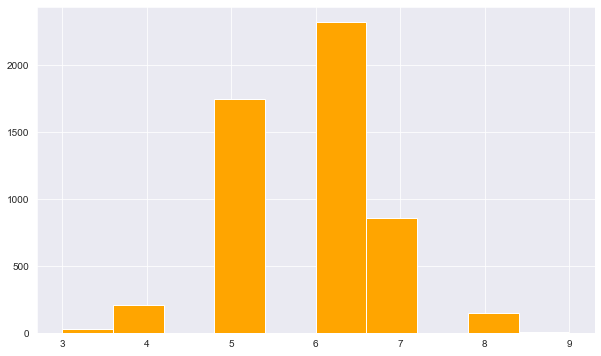

In [9]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(10,6))
plt.hist(df["quality"], color="orange")
plt.show()

#### *From the above plot, the wines with 3,4,8 & 9 have low number of examples but other have a good number of samples; thus removing the 3,4,8 & 9 samples.*

In [10]:
df.value_counts(df['quality'])

quality
6    2323
5    1752
7     856
4     206
8     148
3      30
9       5
dtype: int64

In [11]:
df = df[(df['quality']>4) & (df['quality']<8)]
df = df.reset_index(drop=True)
df.value_counts(df['quality'])

quality
6    2323
5    1752
7     856
dtype: int64

In [21]:
df['fixed acidity'].size

4931

### *Plot after processing*

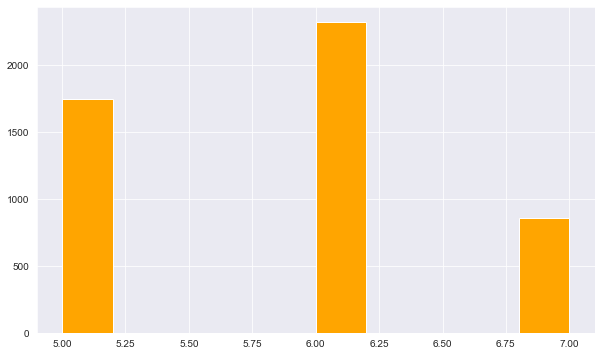

In [18]:
sns.set_style(style="darkgrid")
plt.figure(figsize=(10,6))
plt.hist(df["quality"], color="orange")
plt.show()

## *Train Test Split of the data*

In [19]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,1


In [20]:
df.size

64103

In [22]:
x = df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]
x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4


In [28]:
x

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
4926,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
4927,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
4928,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
4929,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


In [26]:
y = df[['quality', 'is_red']]
y.head()

,quality,is_red
0,5,1
1,5,1
2,5,1
3,6,1
4,5,1


In [27]:
y.size

9862

In [29]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=1)
print(train_x.size)
print(test_x.size)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=1)
print(val_x.size)

43384
10857
8679


In [32]:
train_x

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,7.5,0.65,0.18,7.00,0.088,27.0,94.0,0.99915,3.38,0.77,9.4
3557,6.3,0.27,0.29,12.20,0.044,59.0,196.0,0.99782,3.14,0.40,8.8
3825,8.8,0.27,0.25,5.00,0.024,52.0,99.0,0.99250,2.87,0.49,11.4
1740,6.4,0.45,0.07,1.10,0.030,10.0,131.0,0.99050,2.97,0.28,10.8
1221,7.2,0.53,0.13,2.00,0.058,18.0,22.0,0.99573,3.21,0.68,9.9
...,...,...,...,...,...,...,...,...,...,...,...
1916,7.0,0.21,0.37,7.20,0.042,36.0,167.0,0.99580,3.26,0.56,9.8
606,9.2,0.53,0.24,2.60,0.078,28.0,139.0,0.99788,3.21,0.57,9.5
1255,6.0,0.58,0.20,2.40,0.075,15.0,50.0,0.99467,3.58,0.67,12.5
959,6.8,0.66,0.07,1.60,0.070,16.0,61.0,0.99572,3.29,0.60,9.3


## *train_x, train_y, test_x, test_y, val_x, val_y: Are all the sets created*

## *Normalization*

In [43]:
train_stats = train_x.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.221616,1.325297,3.80000,6.40000,7.00000,7.7000,15.60000
volatile acidity,3155.0,0.338929,0.162476,0.08000,0.23000,0.29000,0.4000,1.24000
citric acid,3155.0,0.321569,0.147970,0.00000,0.25000,0.31000,0.4000,1.66000
residual sugar,3155.0,5.155911,4.639632,0.60000,1.80000,2.80000,7.6500,65.80000
chlorides,3155.0,0.056976,0.036802,0.01200,0.03800,0.04700,0.0660,0.61100
free sulfur dioxide,3155.0,30.388590,17.236784,1.00000,17.00000,28.00000,41.0000,131.00000
total sulfur dioxide,3155.0,115.062282,56.706617,6.00000,75.00000,117.00000,156.0000,344.00000
density,3155.0,0.994633,0.003005,0.98711,0.99232,0.99481,0.9968,1.03898
pH,3155.0,3.223201,0.161272,2.72000,3.11000,3.21000,3.3300,4.01000
sulphates,3155.0,0.534051,0.149149,0.22000,0.43000,0.51000,0.6000,1.95000


In [46]:
# train_x.mean()

In [47]:
# train_x.std()

In [48]:
# Normalize

norm_train_x = (train_x - train_x.mean())/train_x.std()
norm_train_x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,0.210054,1.914565,-0.956741,0.397464,0.842996,-0.196591,-0.371425,1.503235,0.972264,1.581966,-0.956534
3557,-0.695404,-0.424239,-0.213347,1.518243,-0.352585,1.659904,1.427306,1.060647,-0.515907,-0.898768,-1.476170
3825,1.190966,-0.424239,-0.483672,-0.033604,-0.896032,1.253796,-0.283252,-0.709707,-2.190100,-0.295346,0.775586
1740,-0.619949,0.683616,-1.700136,-0.874188,-0.732998,-1.182853,0.281056,-1.375253,-1.570029,-1.703331,0.255950
1221,-0.016311,1.175995,-1.294648,-0.680207,0.027827,-0.718730,-1.641119,0.365151,-0.081857,0.978544,-0.523504


In [49]:
norm_val_x = (val_x - train_x.mean())/train_x.std()
norm_val_x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
4149,0.134599,-0.731976,-0.348510,-0.766421,0.000655,0.847688,-0.300887,-0.546648,0.414200,-0.630581,-0.523504
4340,-0.846313,-0.547333,-0.280928,1.044067,-0.053690,1.485858,0.281056,-0.210547,-0.019850,-1.234002,0.342556
2045,-0.619949,-0.362691,0.597629,0.354358,-0.325413,1.775935,1.779999,0.188781,-0.825943,-0.496487,-0.956534
1966,-0.846313,-0.362691,0.192141,1.647564,-0.243896,1.891966,2.009249,0.954159,-0.887950,-0.898768,-1.389564
3452,-0.242675,0.375878,-0.145766,1.173388,-0.651481,-0.370637,-0.494868,-0.659791,-0.453900,-0.563534,1.988071


In [50]:
norm_test_x = (test_x - train_x.mean())/train_x.std()
norm_test_x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
2372,-0.242675,-0.670428,-0.551254,1.949312,-0.108035,-0.660714,-0.371425,1.187100,-0.329886,-0.228299,-0.783322
1900,-0.469039,-0.793523,-0.078184,1.345815,-0.488447,0.905703,0.880633,1.103907,1.158285,-0.630581,-0.610110
275,1.266420,0.560521,0.867954,-0.701761,-0.135207,-1.414915,-1.746926,0.055672,0.786243,1.112638,1.728253
3276,-0.619949,2.099207,-0.416091,-0.378459,0.326722,-0.312622,0.545575,-0.386917,-0.267879,-0.898768,-1.043140
2360,-0.469039,-0.670428,-0.416091,-0.831081,-0.325413,-0.834761,0.228152,-0.410211,0.848250,0.442169,-0.436898


## *Model Development*

In [60]:
# Initialize base model
def base_model(inputs):
    x = Dense(128, activation = 'relu', name = "First_Dense")(inputs)
    x = Dense(128, activation = 'relu', name='Second_Dense')(x)
    return x

In [61]:
def final_model(inputs):
    x = base_model(inputs)
    # Output layers
    
    wine_quality = Dense(1, name='Wine_Quality')(x)
    wine_type = Dense(1, activation='sigmoid', name="Wine_Type")(x)
    model = Model(inputs = inputs, outputs =[wine_quality, wine_type])
    return model

## *Compile the model*

In [62]:
inputs = Input(shape=(11,))
model = final_model(inputs)

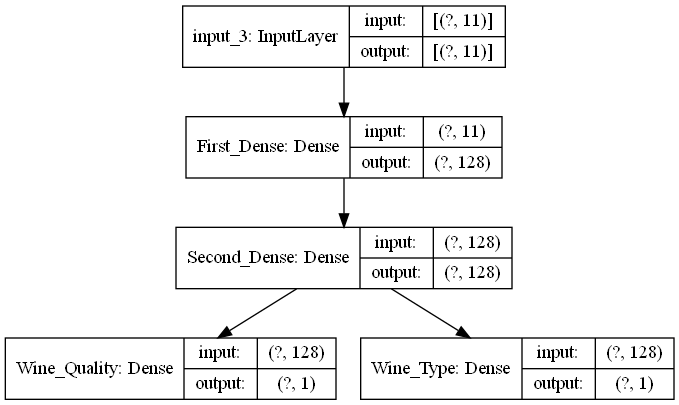

In [63]:
keras.utils.plot_model(model, show_shapes= True, show_layer_names=True)

In [100]:
model.compile(optimizer = keras.optimizers.RMSprop(learning_rate= 0.0001), 
              loss = {'Wine_Type':'binary_crossentropy',
                      'Wine_Quality': 'mean_squared_error'},
              metrics = {'Wine_Type': 'accuracy',
                         'Wine_Quality': tf.keras.metrics.RootMeanSquaredError()},
             )

In [101]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
First_Dense (Dense)             (None, 128)          1536        input_3[0][0]                    
__________________________________________________________________________________________________
Second_Dense (Dense)            (None, 128)          16512       First_Dense[0][0]                
__________________________________________________________________________________________________
Wine_Quality (Dense)            (None, 1)            129         Second_Dense[0][0]               
_______________________________________________________________________________________

## *Train the model*

In [94]:
is_red = train_y['is_red']
is_red = np.array(is_red)
quality = train_y['quality']
quality = np.array(quality)
train_y = (quality, is_red)

In [95]:
train_y

(array([5, 6, 5, ..., 6, 5, 5], dtype=int64),
 array([1, 0, 0, ..., 1, 1, 0], dtype=int64))

In [96]:
is_red = val_y['is_red']
is_red = np.array(is_red)
quality = val_y['quality']
quality = np.array(quality)
val_y = (quality, is_red)

In [103]:
is_red = test_y['is_red']
is_red = np.array(is_red)
quality = test_y['quality']
quality = np.array(quality)
test_y = (quality, is_red)

In [102]:
history = model.fit(norm_train_x, train_y, 
                    epochs=180, 
                    validation_data=(norm_val_x, val_y))

Epoch 1/180
99/99 [==============================] - 2s 16ms/step - loss: 23.2641 - Wine_Quality_loss: 22.5111 - Wine_Type_loss: 0.7531 - Wine_Quality_root_mean_squared_error: 4.7446 - Wine_Type_accuracy: 0.2802 - val_loss: 14.9148 - val_Wine_Quality_loss: 14.2052 - val_Wine_Type_loss: 0.7096 - val_Wine_Quality_root_mean_squared_error: 3.7690 - val_Wine_Type_accuracy: 0.4816
Epoch 2/180
99/99 [==============================] - 0s 4ms/step - loss: 8.9329 - Wine_Quality_loss: 8.2718 - Wine_Type_loss: 0.6611 - Wine_Quality_root_mean_squared_error: 2.8761 - Wine_Type_accuracy: 0.6818 - val_loss: 4.5573 - val_Wine_Quality_loss: 3.9463 - val_Wine_Type_loss: 0.6109 - val_Wine_Quality_root_mean_squared_error: 1.9865 - val_Wine_Type_accuracy: 0.8441
Epoch 3/180
99/99 [==============================] - 0s 4ms/step - loss: 3.2378 - Wine_Quality_loss: 2.6950 - Wine_Type_loss: 0.5427 - Wine_Quality_root_mean_squared_error: 1.6417 - Wine_Type_accuracy: 0.8304 - val_loss: 2.6698 - val_Wine_Quality_lo

## *Analyze Model's performance*

In [105]:
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_x, y=val_y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')

25/25 [==============================] - 0s 880us/step - loss: 0.3365 - Wine_Quality_loss: 0.3111 - Wine_Type_loss: 0.0254 - Wine_Quality_root_mean_squared_error: 0.5578 - Wine_Type_accuracy: 0.9949

loss: 0.336535781621933
wine_quality_loss: 0.3111044764518738
wine_type_loss: 0.02543131448328495
wine_quality_rmse: 0.557767391204834
wine_type_accuracy: 0.9949302673339844


In [111]:
predictions = model.predict(norm_test_x)
quality_preds = predictions[0]
type_preds = predictions[1]

### *Plot utilities*

In [125]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()
    
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

## *Metrics Plots* 

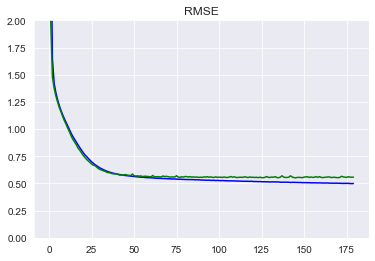

In [126]:
plot_metrics('Wine_Quality_root_mean_squared_error', 'RMSE', ylim=2)

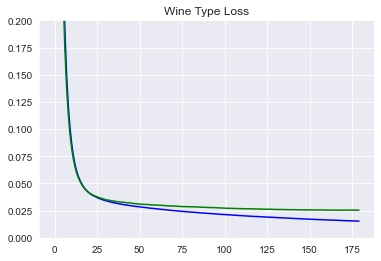

In [127]:
plot_metrics('Wine_Type_loss', 'Wine Type Loss', ylim=0.2)

## *Confusion Matrix*

<ipython-input-125-3c2bb5135d98>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-125-3c2bb5135d98>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


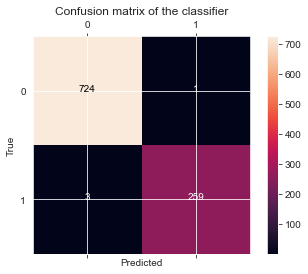

In [132]:
plot_confusion_matrix(test_y[1], np.round(type_preds), title='Wine Type', labels = [0, 1])

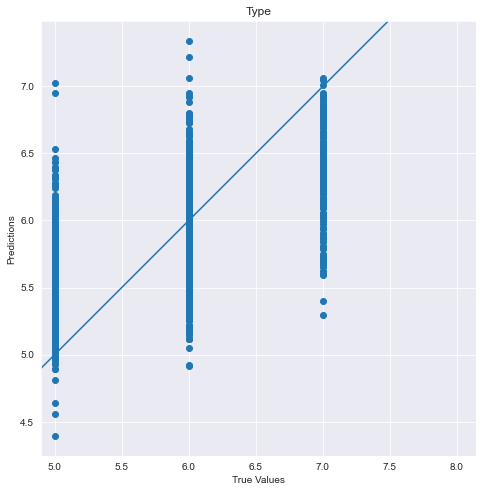

In [137]:
plt.figure(figsize=(10,8))
scatter_plot = plot_diff(test_y[0], quality_preds, title='Type')